In [210]:
import os
import sys
from wholeslidedata.image.wholeslideimage import WholeSlideImage
from wholeslidedata.annotation.wholeslideannotation import WholeSlideAnnotation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm
from wholeslidedata.iterators import create_batch_iterator
sys.path.insert(1, os.path.join(sys.path[0], '../..'))
from utils import plot_batch, colors_1
import segmentation_models_pytorch as smp
import argparse
from train_ensemble import Ensemble
from confidence_calibration import avg_entropy_sk_per_patch
from preprocessing import tissue_mask_batch, get_preprocessing
from train_segmentation import load_trained_segmentation_model
from train_ensemble import load_model, Ensemble, SingleModel
from confidence_calibration import avg_entropy_sk, plot_class_probabilities_sample, plot_pred_sample, ece, brier_score, avg_entropy_sk_per_patch

from matplotlib.patches import Circle, Rectangle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)

from nn_archs.set_transformer import SetTransformer
from train_slide_classification import SlideGradeModel
from metrics_lib import _validate_probabilities
from skimage.filters import gaussian
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

from sklearn.metrics import cohen_kappa_score, accuracy_score, roc_auc_score, confusion_matrix, f1_score, roc_curve, auc, precision_score, recall_score
from utils import plot_confusion_matrix, plot_roc_curves
import seaborn as sns
from typing import List
from wholeslidedata.annotation.structures import Annotation, Point, Polygon
from matplotlib.lines import Line2D

In [255]:
def plot_annotations(
    annotations: List[Annotation],
    ax=None,
    color_map=None,
    title="",
    use_base_coordinates=False,
    scale=1.0,
    shift=None,
    alpha=None,
    lw=3
):
    ax = ax or plt
    


    for annotation in annotations:
        if annotation.label.name == 'ndbe-g':
            label_name = 'NDBE'
        elif annotation.label.name == 'lgd-g':
            label_name = 'LGD'
        elif annotation.label.name == 'hgd-g':
            label_name = 'HGD'
        
        color = (
            color_map[annotation.label.name]
            if color_map is not None
            else annotation.label.color
        )

        if use_base_coordinates:
            coordinates = annotation.base_coordinates * scale
        else:
            coordinates = annotation.coordinates * scale
            
        if shift is not None:
            coordinates = (annotation.coordinates + shift) 

        if isinstance(annotation, Point):
            ax.scatter(*coordinates, color=annotation.label.color)
        elif isinstance(annotation, Polygon):
            ax.plot(*list(zip(*coordinates)), color=color, linewidth=lw, label=label_name, alpha=alpha)
        else:
            raise ValueError(f"invalid annotation {type(annotation)}")

    if ax == plt:
        plt.axis("equal")
    else:
        ax.axis("equal")
        ax.set_title(title)

In [152]:
def extract_segmentation(model, generator, preprocessing, device, n_classes=4):
    """ 

    Args:
            image: (H, W, C_in)
            model:
            generator:
            preprocessing:
            device:

    Returns:
            segmentation: (H, W, C_out)
            
    """
    tile_size = generator.tile_size
    h, w = generator.image.shape[0], generator.image.shape[1]
    probablity_map = np.zeros((h, w, n_classes))                # (H, W, nr_classes)
    prediction_counts = np.zeros((h, w))                        # (H, W)
    generator = generator.get_generator()
    
    with torch.no_grad():
        for idx, (x_np, loc) in enumerate(tqdm(generator)):
            
            # get location
            x_coord, y_coord = loc
            
            # pre process and put on device
            x = preprocessing(image=np.expand_dims(x_np, axis=0))['image'].to(device)
            y = torch.zeros_like(x)
  
            # forward
            y_hat = np.transpose(model.forward(x, y).squeeze(), (1, 2, 0))        
        
            # (1) put the prediction in the prob map
            probablity_map[x_coord: x_coord + tile_size, y_coord: y_coord + tile_size] += y_hat 
            
            # (2) put the count in the count map
            prediction_counts[x_coord: x_coord + tile_size, y_coord: y_coord + tile_size] += 1 

    prediction_counts = np.where(prediction_counts == 0, 1, prediction_counts)     
    final_probablity_map = probablity_map / prediction_counts[:, :, None]
    _validate_probabilities(final_probablity_map)

    return final_probablity_map, prediction_counts

In [153]:
class TileGenerator:
    '''Generates tiles for Numpy images
    '''
    def __init__(self, image, step_size, tile_size):
        
        self.image = image
        self.tile_size = tile_size
        self.step_size = step_size
    
    def get_generator(self):
        img = self.image
        width, height = img.shape[0], img.shape[1]
        x_tiles = int(np.floor(width/self.step_size))
        y_tiles = int(np.floor(height/self.step_size))

        for y in range(y_tiles):
            for x in range(x_tiles):
                x_coord = int(np.round(x*self.step_size))
                y_coord = int(np.round(y*self.step_size))
                tile = img[x_coord: x_coord + self.tile_size, y_coord: y_coord + self.tile_size]
                centre_coord = (x_coord, y_coord)

                # remove when doesnt fit
                if tile.shape == (self.tile_size, self.tile_size, 3):
                    yield tile, centre_coord

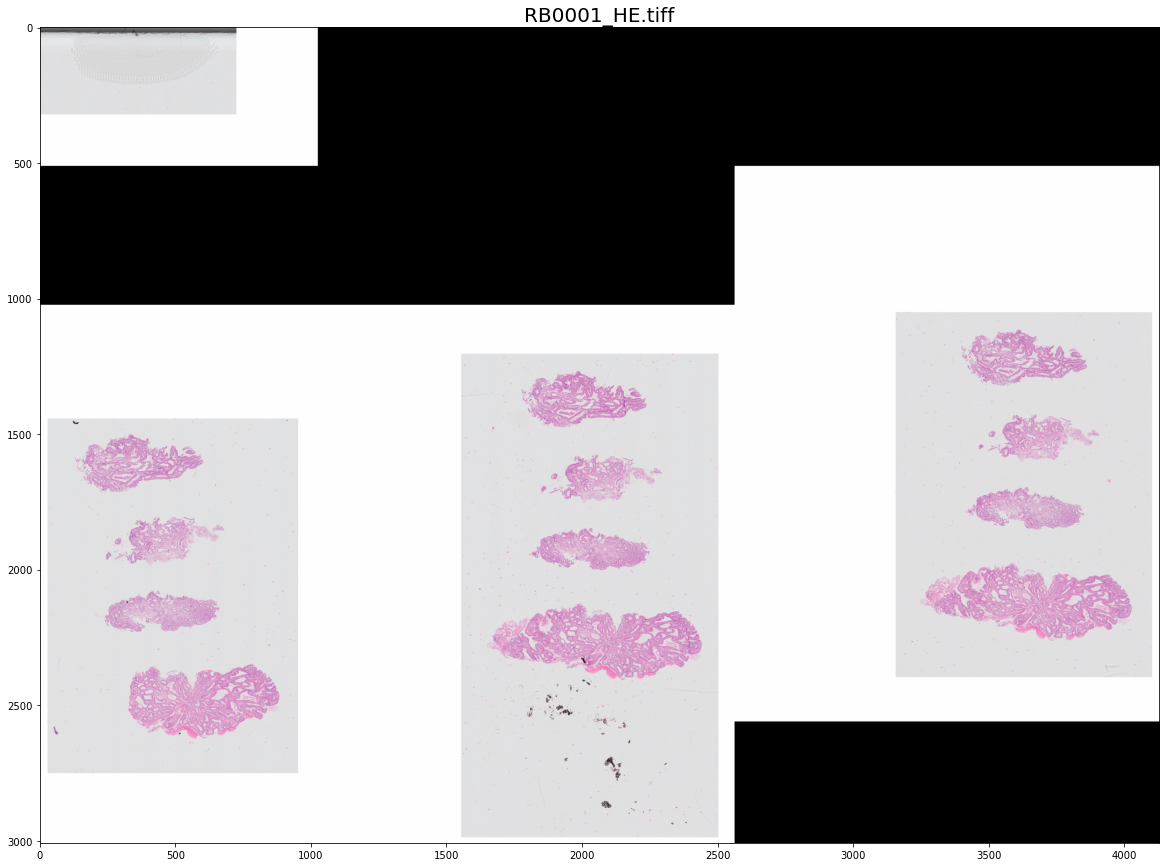

In [375]:
example = 1
internal_test_examples = ['ASL/ASL08_1_HE', 'ASL/ASL26_1_HE', 'ASL35_1_HE',
                          'LANS/RL086_01_02_01_HE', 'LANS/RL059_01_03_01_HE', 'LANS/RL185_01_01_01_HE', 'LANS/RL062_01_01_01_HE', 'LANS/RL007_01_02_01_HE', 'LANS/RL044_01_02_01_HE',
                          'RBE/ROCT38_XII-HE1', 'RBE/ROCT38_XI-HE1', 'RBE/ROCT31_III-HE1', 'RBE/RBE-00115_HE']

example_path = internal_test_examples[example]
example_path = 'RBE/RBE-00149_HE'
wsi_path = os.path.join('/data/archief/AMC-data/Barrett/', example_path) + '.tiff'
wsa_path = os.path.join('/data/archief/AMC-data/Barrett/', example_path) + '.xml'

# BOLERO
bolero_dir = '/data/archief/AMC-data/Barrett/Bolero/'
bolero_tiffs = sorted([f for f in os.listdir(bolero_dir) if 'tiff' in f])
bolero_xmls = sorted([f for f in os.listdir(bolero_dir) if 'xml' in f and not 'old' in f])

wsi_path = os.path.join(bolero_dir, bolero_tiffs[0]) 
wsa_path = os.path.join(bolero_dir, bolero_xmls[0])

wsa = WholeSlideAnnotation(wsa_path, labels=['biopsy-outlines'])
case_name = wsi_path.split('/')[-1]

# open a WSI
with WholeSlideImage(wsi_path, backend='openslide') as wsi:   
    # extract the whole slide
    slide_spacing=8.0
    slide = wsi.get_slide(spacing=slide_spacing)
    plt.figure(figsize=(25, 15))
    plt.title(case_name, fontsize=20)
    plt.imshow(slide)
    plt.show()

In [379]:
print("Found {} biopsy outline(s).".format(len(wsa.annotations)))

# get the biopsy
biopsy_nr = 0
bottom_left, top_right = wsa.annotations[biopsy_nr].coordinates[0], wsa.annotations[biopsy_nr].coordinates[2]
tile_size = 512

wsa = WholeSlideAnnotation(wsa_path, labels=['biopsy-outlines'])

# get the centre of the biopsy
centre = bottom_left + ((top_right - bottom_left) / 2)
x = int(centre[0])
y = int(centre[1])
diff = top_right - bottom_left
width = int(diff[0]  + tile_size)
height = int(diff[1]  + tile_size)
print('x, y: {}, {}'.format(x, y))
print('width, height: {}, {}'.format(width, height))

Found 4 biopsy outline(s).
x, y: 116272, 67824
width, height: 25536, 9760


In [380]:
LABELS = ['NDBE-G', 'LGD-G', 'HGD-G']
wsa_grades = WholeSlideAnnotation(wsa_path, labels=LABELS)

In [384]:
for annotation in wsa_grades.annotations:
    color = (color_map[annotation.label.name])
        
# filter all under y=16k
filtered_annotations = []
for annotation in wsa_grades.annotations:
    if (annotation.coordinates[0][1]) > 60000 and (annotation.coordinates[0][1] < 75000):
        filtered_annotations.append(annotation)

In [382]:
# load ensemble of segmentation models
exp_dir = '/data/archief/AMC-data/Barrett/experiments/barrett_gland_grading/3_classes/Ensemble_m5_UNet++_CE_IN/'
preprocessing = get_preprocessing(smp.encoders.get_preprocessing_fn('efficientnet-b4', 'imagenet'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ensemble_m5_CE_IN = Ensemble(exp_dir, device=device, m=5)

Loading model: unet++, weights: imagenet
Loaded model from: /data/archief/AMC-data/Barrett/experiments/barrett_gland_grading/3_classes/Ensemble_m5_UNet++_CE_IN/net_0/checkpoints/best_model.pt

Loading model: unet++, weights: imagenet
Loaded model from: /data/archief/AMC-data/Barrett/experiments/barrett_gland_grading/3_classes/Ensemble_m5_UNet++_CE_IN/net_1/checkpoints/best_model.pt

Loading model: unet++, weights: imagenet
Loaded model from: /data/archief/AMC-data/Barrett/experiments/barrett_gland_grading/3_classes/Ensemble_m5_UNet++_CE_IN/net_2/checkpoints/best_model.pt

Loading model: unet++, weights: imagenet
Loaded model from: /data/archief/AMC-data/Barrett/experiments/barrett_gland_grading/3_classes/Ensemble_m5_UNet++_CE_IN/net_3/checkpoints/best_model.pt

Loading model: unet++, weights: imagenet
Loaded model from: /data/archief/AMC-data/Barrett/experiments/barrett_gland_grading/3_classes/Ensemble_m5_UNet++_CE_IN/net_4/checkpoints/best_model.pt



x, y: 116272, 67824
width, height: 6768, 2824
Shape of patch: (2824, 6768, 3)


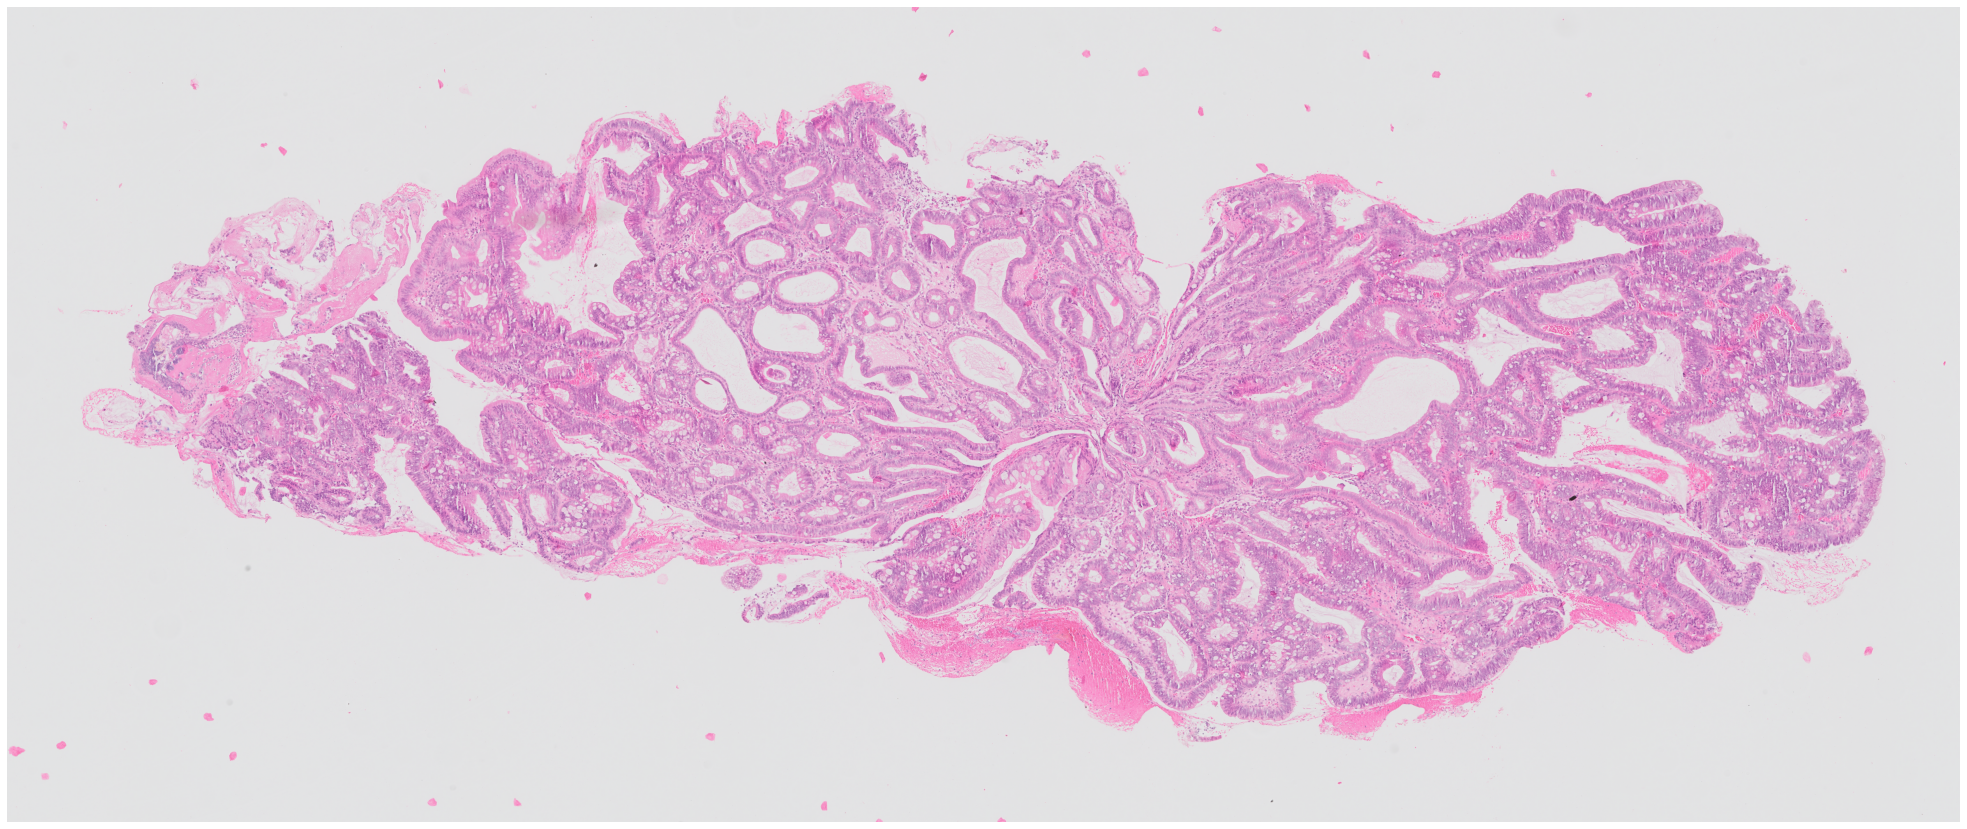

In [385]:
# smaller stepsize to get less stitching artifacts
tile_size = 512
step_size = 256
spacing = 1

with WholeSlideImage(wsi_path, backend='openslide') as wsi:
    patch = wsi.get_patch(x, y, width, height, spacing=spacing)
    
# get the centre of the biopsy
centre = bottom_left + ((top_right - bottom_left) / 2)
x = int(centre[0])
y = int(centre[1])
diff = top_right - bottom_left
width = int(diff[0] // 4 + tile_size) 
height = int(diff[1] // 4 + tile_size) 
print('x, y: {}, {}'.format(x, y))
print('width, height: {}, {}'.format(width, height))
width_crop = int(diff[0] + tile_size) // 4 
height_crop = int(diff[1] + tile_size) // 4  

with WholeSlideImage(wsi_path, backend='openslide') as wsi:
    patch = wsi.get_patch(x, y, width, height, spacing=1)
    
print('Shape of patch: {}'.format(patch.shape))
plt.figure(figsize=(35, 20))
plt.imshow(patch)
plt.axis('off')
plt.show()

In [386]:
tile_gen = TileGenerator(image=patch, step_size=step_size // 2, tile_size=tile_size)
segmentation, counts = extract_segmentation(model=ensemble_m5_CE_IN, generator=tile_gen, preprocessing=preprocessing, device=device)

0it [00:00, ?it/s]

In [387]:
def crop_center(img, cropx, cropy):
    y, x, _  = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty + cropy, startx:startx + cropx, :]

In [388]:
# crop patch and segmentation
patch = crop_center(patch, width_crop, height_crop)
segmentation = crop_center(segmentation, width_crop, height_crop)

In [389]:
# define cmap and plot stuff
cmap = plt.cm.jet
my_cmap = cmap(np.arange(cmap.N))                # get the colormap colours
my_cmap[:, -1] = np.linspace(0.2, 0.7, cmap.N)   # set alpha as a linear gradient
my_cmap = ListedColormap(my_cmap)                # create new colourmap
im_ratio = patch.shape[0] / patch.shape[1]

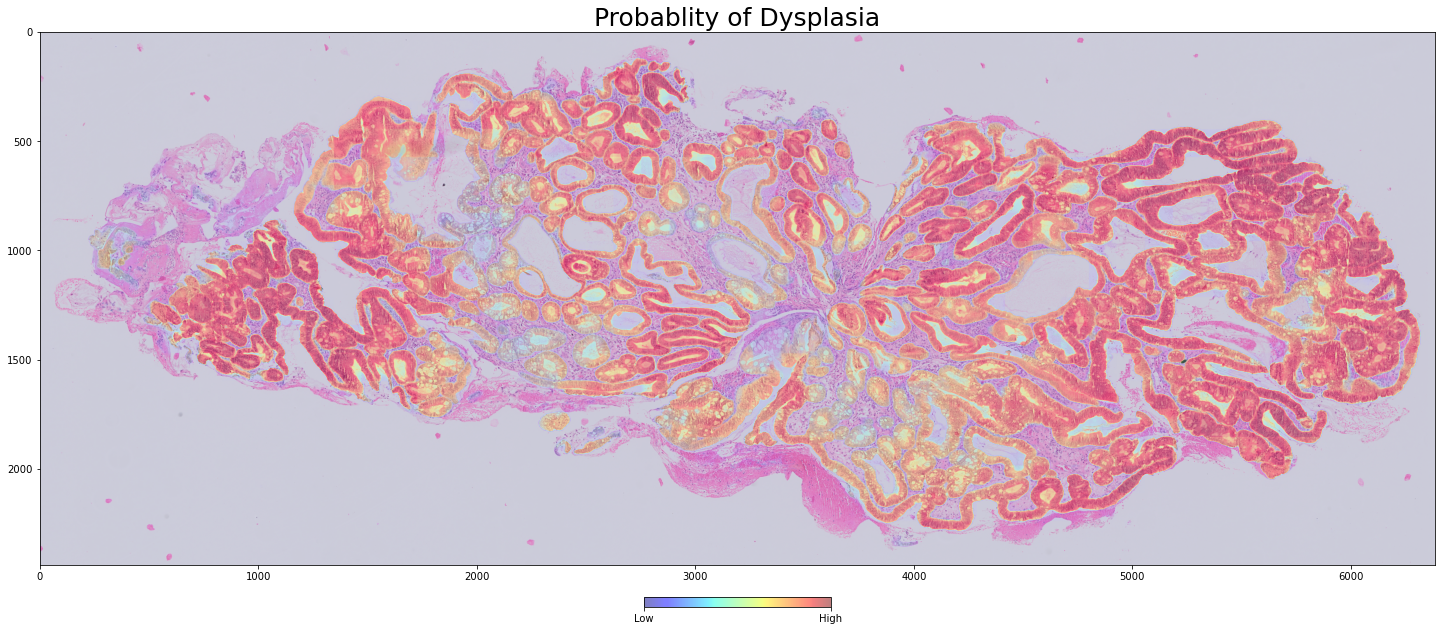

In [390]:
# dysplasia prob
y_hat_dys = segmentation[:, :, 2] + segmentation[:, :, 3]
y_hat_hard = np.argmax(segmentation, axis=2)
plt.figure(figsize=(25, 15))
plt.imshow(patch)
plt.imshow(y_hat_dys, cmap=my_cmap, alpha=0.5, vmin=0, vmax=1)
cbar = plt.colorbar(fraction=0.03 * im_ratio, pad=0.04, orientation='horizontal', ticks=[0, 1])
cbar.ax.set_xticklabels(['Low', 'High'])
plt.title('Probablity of Dysplasia', fontsize=25)
plt.show()

In [391]:
# colors 
ndbe_color = my_cmap(0.2)
lgd_color = my_cmap(0.7)
hgd_color = my_cmap(0.89)
color_map = {'ndbe-g': ndbe_color, 'lgd-g': lgd_color, 'hgd-g': hgd_color}
alpha = 1

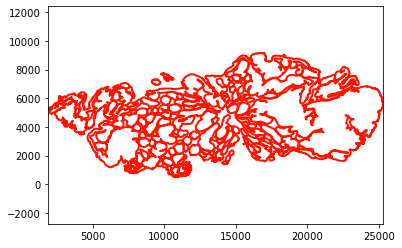

In [431]:
plt.figure()
plot_annotations(filtered_annotations, shift=-bottom_left + 0.5*tile_size, color_map=color_map, alpha=alpha, lw=2)
plt.margins(x=0)
plt.show()
# for ann in filtered_annotations:
#     print(ann.coordinates)

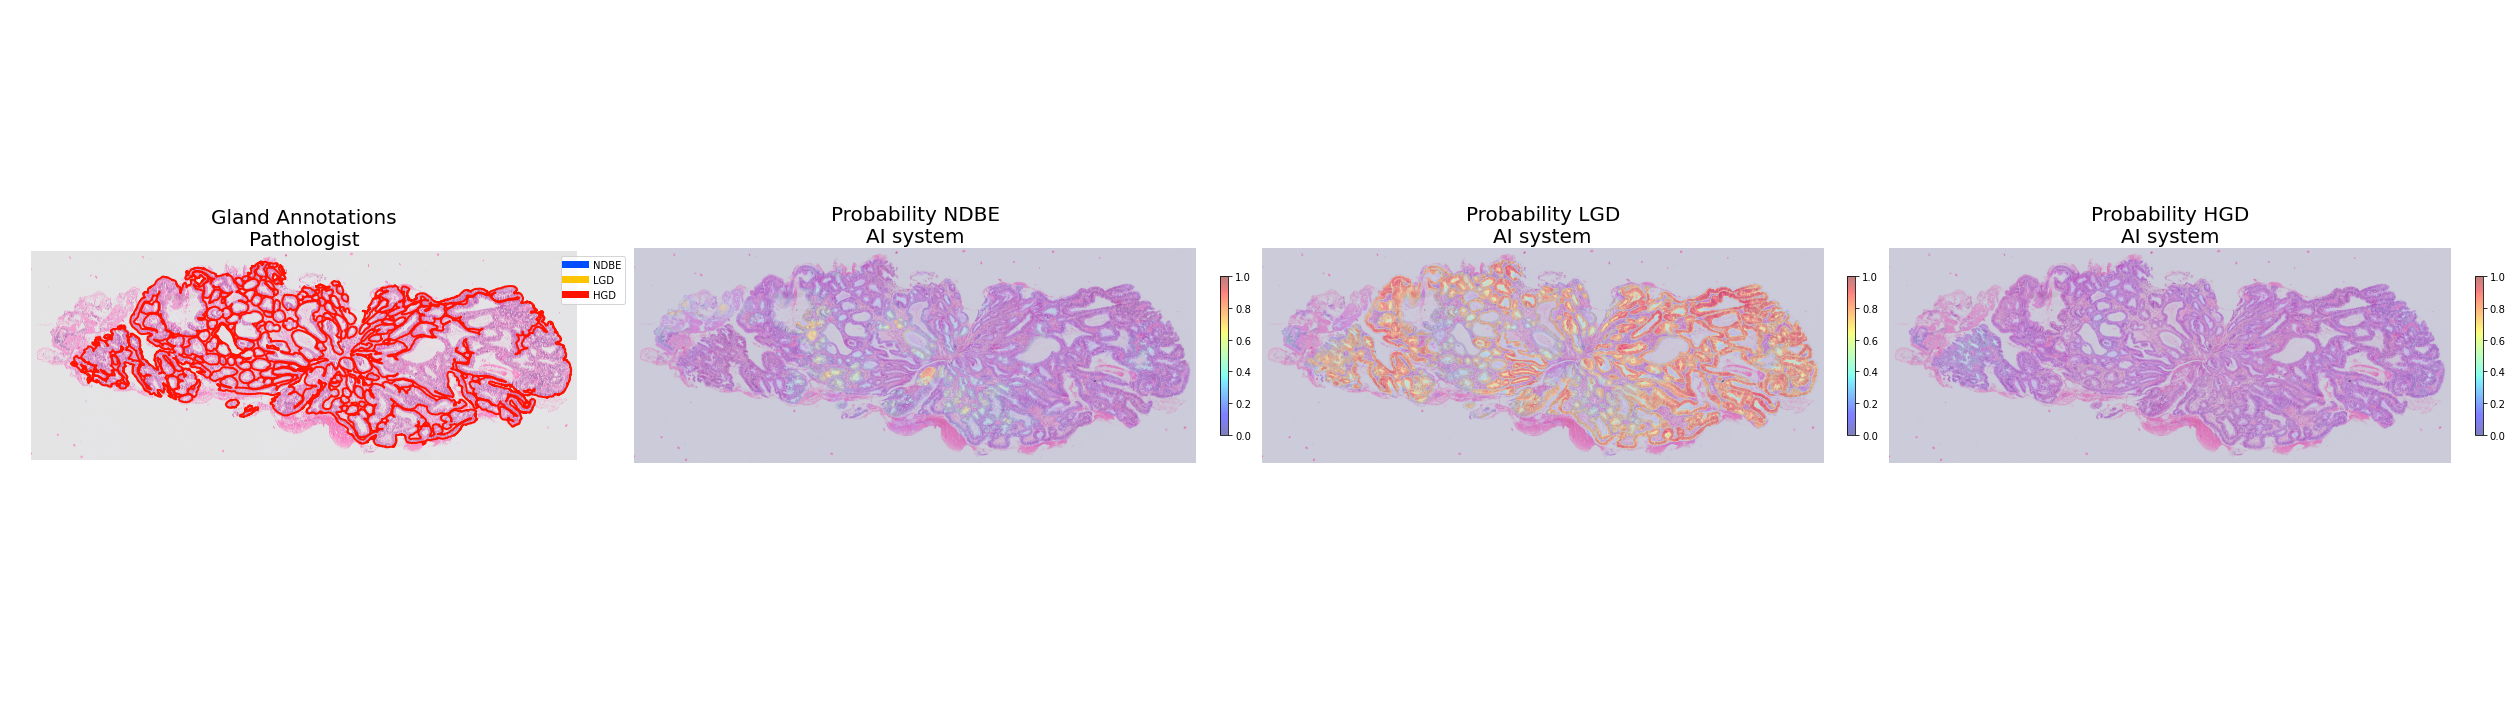

In [432]:
# get the centre of the biopsy (HIGH RES)
centre = bottom_left + ((top_right - bottom_left) / 2)
x = int(centre[0])
y = int(centre[1])
diff = top_right - bottom_left
width = int(diff[0] + tile_size)
height = int(diff[1] + tile_size)

with WholeSlideImage(wsi_path, backend='openslide') as wsi:
    patch_high_res = wsi.get_patch(x, y, width, height, spacing=0.25)
    
# ground truth
plt.figure(figsize=(35, 10))
plt.subplot(141)
plt.axis('off')
plt.imshow(patch_high_res, extent=[0, 25536, 9760, 0])
plt.title('Gland Annotations\nPathologist', fontsize=20, y=0.65)
plot_annotations(filtered_annotations, shift=-bottom_left + 0.5*tile_size, color_map=color_map, alpha=alpha, lw=2)

# custom legend
legend_elements = [Line2D([0], [0], color=ndbe_color, alpha=alpha, lw=2, label='NDBE'),
                   Line2D([0], [0], color=lgd_color, alpha=alpha, lw=2, label='LGD'),
                   Line2D([0], [0], color=hgd_color, alpha=alpha, lw=2, label='HGD')]

leg = plt.legend(handles=legend_elements, fontsize=10, loc='upper right', bbox_to_anchor=(1.05, 0.65))
for line in leg.get_lines():
    line.set_linewidth(7)

# heatmap
plt.subplot(142)
plt.imshow(patch)
plt.title('Probability NDBE\nAI system', fontsize=20)
plt.imshow(segmentation[:, :, 1], cmap=my_cmap, alpha=0.5, vmin=0, vmax=1)
plt.colorbar(fraction=0.035*im_ratio, pad=0.04)
plt.axis('off')

plt.subplot(143)
plt.imshow(patch)
plt.title('Probability LGD\nAI system', fontsize=20)
plt.imshow(segmentation[:, :, 2], cmap=my_cmap, alpha=0.5, vmin=0, vmax=1)
plt.colorbar(fraction=0.035*im_ratio, pad=0.04)
plt.axis('off')

plt.subplot(144)
plt.imshow(patch)
plt.title('Probability HGD\nAI system', fontsize=20)
plt.imshow(segmentation[:, :, 3], cmap=my_cmap, alpha=0.5, vmin=0, vmax=1)
plt.colorbar(fraction=0.035*im_ratio, pad=0.04)
plt.axis('off')

plt.tight_layout()
plt.savefig('../plots/pathologist_annotations_vs_ai_confus_lgd_hgd.png')
plt.show()

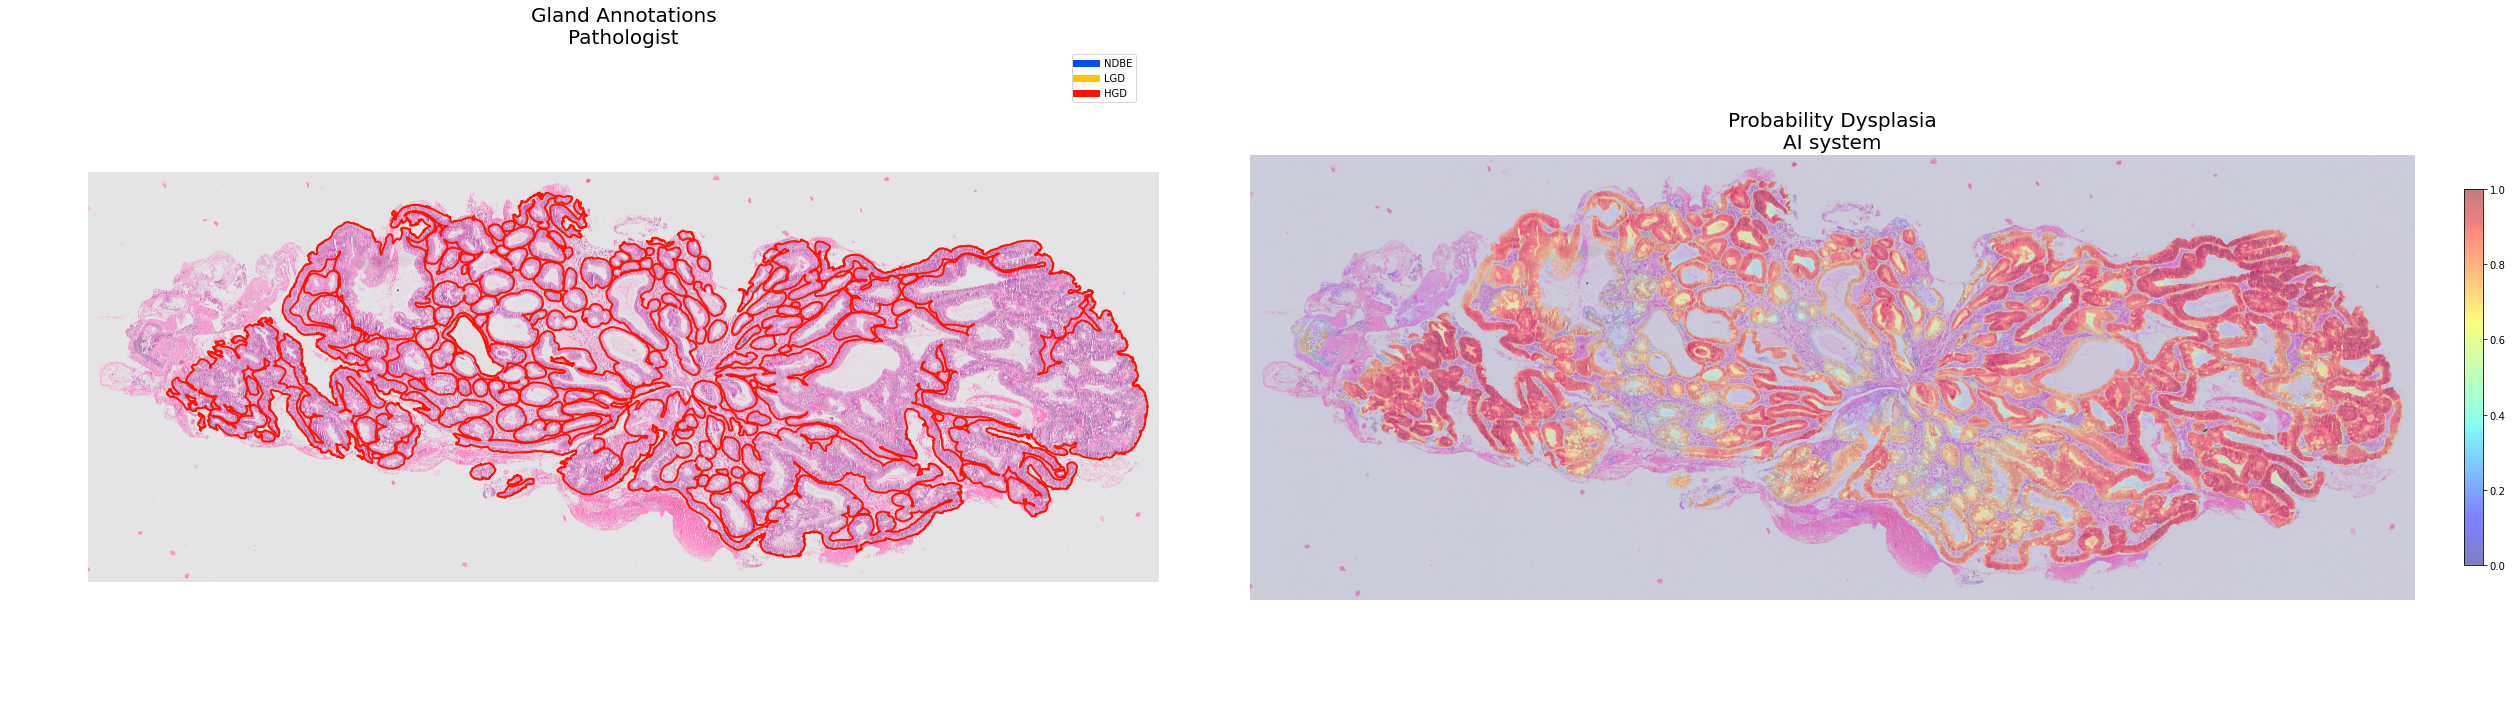

In [393]:
# ground truth
plt.figure(figsize=(35, 10))
plt.subplot(121)
plt.axis('off')
plt.imshow(patch_high_res)
plt.title('Gland Annotations\nPathologist', fontsize=20, y=1)
plot_annotations(filtered_annotations, shift=-bottom_left + 0.5*tile_size, color_map=color_map, alpha=alpha, lw=2)

# custom legend
legend_elements = [Line2D([0], [0], color=ndbe_color, alpha=alpha, lw=2, label='NDBE'),
                   Line2D([0], [0], color=lgd_color, alpha=alpha, lw=2, label='LGD'),
                   Line2D([0], [0], color=hgd_color, alpha=alpha, lw=2, label='HGD')]

leg = plt.legend(handles=legend_elements, fontsize=10, loc='upper right', bbox_to_anchor=(0.92, 1))
for line in leg.get_lines():
    line.set_linewidth(7)

# heatmap
plt.subplot(122)
plt.imshow(patch)
plt.title('Probability Dysplasia\nAI system', fontsize=20)
plt.imshow(y_hat_dys, cmap=my_cmap, alpha=0.5, vmin=0, vmax=1)
plt.colorbar(fraction=0.04*im_ratio, pad=0.04)
plt.axis('off')

plt.tight_layout()
#plt.savefig('../plots/pathologist_annotations_vs_ai_dys_prob.png')
plt.show()